# imports

In [1]:
import os
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import zscore
from scipy.signal import savgol_filter
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import ward
from scipy.cluster.hierarchy import dendrogram

from aeon.distances import dtw_pairwise_distance

from tslearn.barycenters import dtw_barycenter_averaging

#import statsmodels.api as sm  # module to build a LOWESS model
#import math
#from matplotlib.colors import LinearSegmentedColormap
#from Bio import SeqIO
#from Bio.KEGG.REST import *
#import statistics
#import sys
#import copy

#import yaml
#from scipy.stats import kendalltau
#import scipy.stats as stats
#import scanpy as sc
#import stereo as st
#from timeit import default_timer as timer

#from aeon.clustering import TimeSeriesKMeans
#from aeon.datasets import load_arrow_head
#from sklearn.metrics import rand_score
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score

# Imports and load data
#from aeon.clustering import TimeSeriesKMeans, TimeSeriesKMedoids
#from aeon.datasets import load_unit_test
#from aeon.visualisation import plot_cluster_algorithm
#from aeon.utils.conversion import convert_collection

#from aeon.distances import dtw_distance
#import sys
#import tslearn
#tslearn.__version__



random.seed(1)

# global parameters

In [2]:
out_dir = f"./example/"

In [3]:
region = "dorpal_men"
tsv_files = {"E1S1": "./resource/E16.5_E1S1_meninges_dorsalpallium.tsv",
             "E1S2": "./resource/E16.5_E1S2_meninges_dorsalpallium.tsv",
             "E2S5": "./resource/E16.5_E2S5_meninges_dorsalpallium.tsv",
             "E2S7": "./resource/E16.5_E2S7_meninges_dorsalpallium.tsv"}

## loading data

In [4]:
all_genes_dic = dict()
sample_dic = dict()

tsv_dic = dict()
for sample in tsv_files.keys():
    df = pd.read_csv(tsv_files[sample],
                     sep="\t", 
                     index_col=0, 
                     comment="#")

    df = df[df.columns.drop(list(df.filter(regex='__stdev')))] # remove qc columns from analysis 
    sample_dic[sample] = df

# QC

## plot bin counts

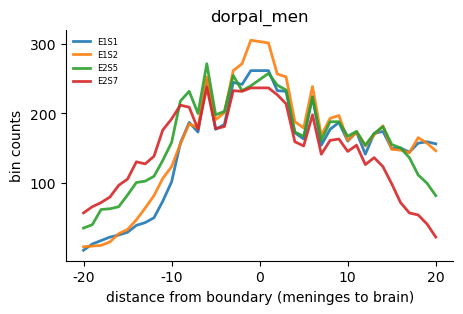

In [5]:
for sample in sample_dic:
    plt.plot(sample_dic[sample][["bin_count"]], 
             linewidth=2, 
             alpha=0.9, 
             label=sample)

ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.yticks([100, 200, 300], labels=[100, 200, 300])
plt.xticks([-20, -10, 0, 10, 20], labels=[-20, -10, 0, 10, 20]) 
plt.title(region)
plt.ylabel("bin counts")
plt.xlabel("distance from boundary (meninges to brain)")
plt.legend(loc="upper left", fontsize=6, frameon=False)
plt.gcf().set_size_inches(5, 3)
plt.show()

We see that more than 10 bins into the meninges, the number of bins covered sharply drops off. In the brain, up to a distance of 15 bins from the boundary is still well covered.

In [8]:
# setting the limits for the boundary distance
distance_range = (-10, 15)

In [6]:
# we remove the "bin_count" column from the dataframes, as we don't need that column anymore
for sample in sample_dic.keys():
    sample_dic[sample] = sample_dic[sample].drop(['bin_count'], axis=1)

## dtw based filtering

We use dynamic time warping to calculate the similarities between gene patterns. We only want to keep genes with a low enough average distance between samples. Before calculating pattern distance, we apply a Savitzky-Golay filter for smoothing and zscore normalization. Additionally, we remove all genes not detected in all samples and genes with high sparsity.

After filtering, we create an average pattern using dtw barycenter averaging.

In [20]:
# sparsity params
sparsity_threshold = 0.5  # fraction of distances that can be 0

# Savitzky-Golay params
window_length = 5
polyorder = 2

# dtw_params
max_iter = 5
dtw_window_size = 2 # width of the constraint band for temporal shift
mean_dtw_threshold = 6

In [21]:
selected_genes_values = []
selected_genes_names = []

for index, gene in enumerate(sample_dic["E1S1"].columns):
    if index % 5000 == 0:
        print(f"{index} out of {len(sample_dic['E1S1'].columns)}")

    data_t = []
    for sample in sample_dic.keys():
        if gene not in sample_dic[sample].columns:
            break # we only want genes that were detected in all samples for this analysis
        d = sample_dic[sample][gene].loc[distance_range[0]:distance_range[1]].values
        if np.count_nonzero(d == 0)/len(d) >= sparsity_threshold:
            break   # we remove genes where more than half of the distances had no expression detected
        d_t = savgol_filter(d, 
                            window_length=window_length, 
                            polyorder=polyorder)
        d_t = zscore(d_t)
        data_t.append(d_t)
        
    if len(data_t) < len(sample_dic.keys()):
        continue
        
    data_t = np.asarray(data_t, dtype="float")
    
    dtw_mat = dtw_pairwise_distance(data_t, window=dtw_window_size/len(d))
    mean_dtw = np.median(dtw_mat[np.triu_indices(dtw_mat.shape[0], k=1)])
    if mean_dtw < mean_dtw_threshold:
        dtw_bary_average = dtw_barycenter_averaging(data_t, max_iter=max_iter, metric_params={"sakoe_chiba_radius":dtw_window_size}).flatten()
        selected_genes_values.append(dtw_bary_average)
        selected_genes_names.append(gene)


selected_genes_values = np.array(selected_genes_values)

0 out of 42126
5000 out of 42126
10000 out of 42126
15000 out of 42126
20000 out of 42126
25000 out of 42126
30000 out of 42126
35000 out of 42126
40000 out of 42126


# clustering

We now calculate the pairwise distance of all barycenter average patterns and prepare the result for ward linkage.

In [27]:
uncondensed = dtw_pairwise_distance(selected_genes_values, 
                                    window=dtw_window_size/len(selected_genes_values[0]))
condensed = squareform(uncondensed)

Applying ward clustering.

In [26]:
ward_result = ward(condensed)

# visualization

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found

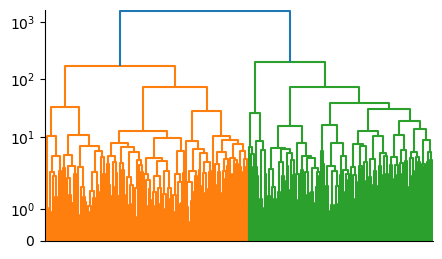

In [28]:
dendrogram(ward_result, truncate_mode="level", no_labels=True, p=10)
plt.gcf().set_size_inches(5, 3)
    
ax = plt.gca()
ax.set_yscale('symlog')
ax.spines[['right', 'top']].set_visible(False)
plt.show()


## creating directory structure that mirrors clustering result

To make the discovery of the tree structure easier, we can create a directory structure mirroring the clustering results.

In [35]:
# the clustering_steps dictionary lists the clusters at each distance in the tree
dct = dict([(i, {i}) for i in range(len(selected_genes_values))])

clustering_steps = dict()
for i, row in enumerate(ward_result, len(selected_genes_values)):
    dct[i] = dct[row[0]].union(dct[row[1]])
    del dct[row[0]]
    del dct[row[1]]
    clustering_steps[row[2]] = list(dct.values())

# this converts the ids into the gene names
clustering_steps_genes = dict()
for step in clustering_steps.keys():
    clustering_steps_genes[step] = []
    for set_of_ids in clustering_steps[step]:
        clustering_steps_genes[step].append({selected_genes_names[s] for s in set_of_ids})

In [33]:
layer_before = clustering_steps_genes[np.max(list(clustering_steps_genes.keys()))]
node_origins = [-1]                                                                # list of cluster origins
clusters = [layer_before[0]]                                                       # clusters[cluster_id] => genes of cluster_id

for node in range(1,len(ward_result)): #-1000):
    distance_to_node = ward_result[:,2][::-1][node]
    
    count_adding_new_clusters = 0
    for i, s in enumerate(clustering_steps_genes[distance_to_node]): # find new clusters
        if count_adding_new_clusters == 2:
            break
        if s not in layer_before : 
            count_adding_new_clusters += 1
            if True:# or len(s) >= min_cluster_size: # barely improves runtime
                clusters.append(s) 

    for i,s in enumerate(clusters[::-1][count_adding_new_clusters:]): # go through list of clusters in reverse, to find parent cluster
        if clusters[len(clusters)-1].issubset(s):                     # both new clusters will have same parent
            node_origins.append(len(clusters)-count_adding_new_clusters-i-1)
            node_origins.append(len(clusters)-count_adding_new_clusters-i-1)
            break

    layer_before = clustering_steps_genes[distance_to_node]

In [43]:
# to get the file path. filepath = tree cluster path
def get_path(index, node_origins):
    parent_node = node_origins[index]
    path = f"{parent_node}/{index}/"
    while parent_node != -1:
        path = f"{node_origins[parent_node]}/{path}"
        parent_node = node_origins[parent_node]

    return path

## creating directories

Now we can create the directory structure, including figures of the patterns in each cluster

In [49]:
plt.close("all")

max_genes_to_plot = 200   # we dont need to plot all genes in the big clusters to get an idea of the shape
min_cluster_size = 5      # minimum cluster size that we still want to plot
start = 0                 # at which cluster we want to start plotting
end = 30                  # at which cluster we want to stop


x = np.arange(distance_range[0], distance_range[1])
x_label = np.delete(np.arange(distance_range[0], 
                              distance_range[1]+1), 
                    np.arange(distance_range[0], 
                              distance_range[1]+1)==0)

for index, cluster in enumerate(clusters[start:end], start):
    path = get_path(index, node_origins)
    path = path.replace("-1/", "")
    if len(cluster) < min_cluster_size:
        continue

    path = f"{out_dir}ward/{path}"
    os.makedirs(path, exist_ok=True)

    max_y = 0
    min_y = 0
    data = []
    for gene in random.sample(cluster, min(max_genes_to_plot, len(cluster))):
        gene_index = np.where(np.array(selected_genes_names) == gene)[0][0]
        #print(gene_index)
        plt.plot(x,
                 selected_genes_values[gene_index],
                 alpha=0.5,
                 color="k"
                 #color=my_colors[all_regions.index(region)]
                )
        data.append(selected_genes_values[gene_index])
        max_y = max(max_y, selected_genes_values[gene_index].max())
        min_y = min(min_y, selected_genes_values[gene_index].min())
        
    plt.xticks(x, labels=x_label)
    bytes = plt.vlines(-0.5, ymin=min_y, ymax=max_y, color="orange", alpha=1, linestyles="dashed", linewidth=3)
    plt.plot(x,
             dtw_barycenter_averaging(data, max_iter=5, metric_params={"sakoe_chiba_radius":1}).flatten(),
             alpha=1,
             color="red",
             linewidth=3)
    plt.title(f"cluster {index}, n={len(data)}")
    plt.savefig(f"{path}/../{index}_patterns.png", dpi=100)
    plt.close()

    with open(f"{path}/../{index}_genes.txt", 'w') as f:
        for gene in sorted(list(cluster)):
            f.write(f"{gene}\n")